# Implementation of LSTM with different time steps

In [145]:
import pandas as pd
import requests
import datetime
import json
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [146]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [147]:

time_series = ['code-changes-lines','issues-active','issues-closed',
                  'contributors-new','reviews','issues-new','reviews-declined']


training_days = 365
repo_id = 25663
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')
base_url = 'http://{}:{}/api/unstable/repo-groups/25157/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
begin_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
index = pd.date_range(begin_date, periods=training_days, freq='D')
df = pd.DataFrame(index)
df.columns = ['date']
df['date'] = df['date'].astype(str)
#df = pd.DataFrame(columns=['date']) 
#df.columns=['date']

for endpoint in time_series:
    
    
    url = base_url + endpoint
    print("Hitting endpoint: " + url + "\n")
    try:
        data = requests.get(url=url).json()
        
    except:
        data = json.loads(json.dumps(requests.get(url=url).text))

    if len(data) == 0:
        print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
        continue
                
    if 'date' not in data[0]:
        print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
        continue
            
    metric_df = pd.DataFrame.from_records(data)
    metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
    metric_df['date'] = metric_df['date'].astype(str)
    extra=['repo','rg','year','week']
    for column in metric_df.columns:
        if any(x in column for x in extra):
            metric_df.drop(column,axis=1,inplace=True)
            
    df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
    metric_df.drop('date',axis=1,inplace=True)
    df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)


Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/code-changes-lines

Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/issues-active

Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/issues-closed

Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/contributors-new

Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/reviews

Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/issues-new

Hitting endpoint: http://localhost:5000/api/unstable/repo-groups/25157/repos/25663/reviews-declined



In [148]:
df.head()

,date,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,reviews-declined _ pull_requests
0,2019-06-07,25.0,54.0,3.0,NaN,NaN,1.0,NaN,NaN
1,2019-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2019-06-09,332.0,145.0,2.0,1.0,3.0,2.0,4.0,NaN
3,2019-06-10,800.0,486.0,1.0,12.0,2.0,NaN,6.0,1.0
4,2019-06-11,619.0,286.0,NaN,6.0,3.0,NaN,8.0,2.0


In [153]:
df_frame = df.iloc[:350,[1,2,4,5,6,7]]

In [154]:
df_frame.tail(14)

,code-changes-lines _ added,code-changes-lines _ removed,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues
336,NaN,NaN,NaN,2.0,1.0,2.0
337,NaN,NaN,2.0,1.0,2.0,2.0
338,NaN,NaN,8.0,3.0,2.0,2.0
339,NaN,NaN,7.0,3.0,3.0,4.0
340,NaN,NaN,7.0,5.0,4.0,10.0
341,NaN,NaN,5.0,5.0,3.0,8.0
342,NaN,NaN,3.0,2.0,4.0,5.0
343,NaN,NaN,NaN,2.0,NaN,3.0
344,NaN,NaN,2.0,2.0,NaN,NaN
345,NaN,NaN,7.0,2.0,1.0,4.0


In [155]:
df_frame = df_frame.fillna(0)

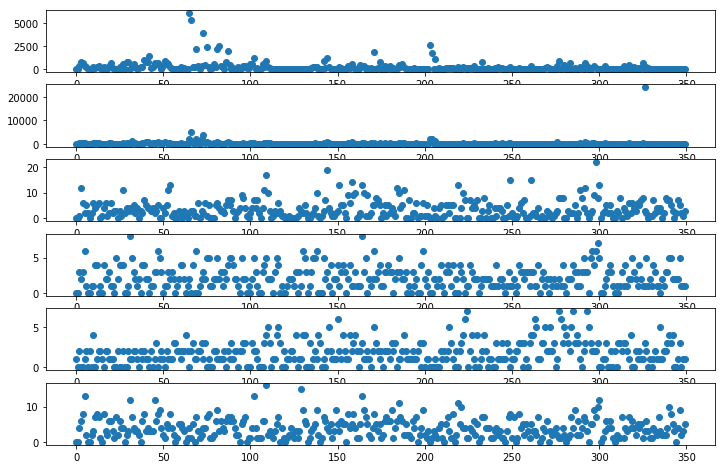

In [156]:

plt.figure(figsize=(12,8))

plt.subplot(6,1, 1)
plt.plot(df_frame.iloc[:,0],'o')
plt.subplot(6,1, 2)
plt.plot(df_frame.iloc[:,1],'o')
plt.subplot(6,1, 3)
plt.plot(df_frame.iloc[:,2],'o')
plt.subplot(6,1, 4)
plt.plot(df_frame.iloc[:,3],'o')
plt.subplot(6,1, 5)
plt.plot(df_frame.iloc[:,4],'o')
plt.subplot(6,1, 6)
plt.plot(df_frame.iloc[:,5],'o')


### After ploting for one month ,we can see that it follows a weekly pattern

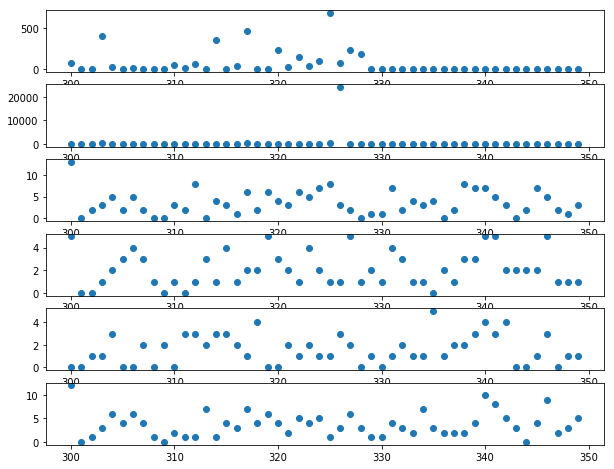

In [157]:
plt.figure(figsize=(10,8))

plt.subplot(6,1, 1)
plt.plot(df_frame.iloc[300:350,0],'o')
plt.subplot(6,1, 2)
plt.plot(df_frame.iloc[300:350,1],'o')
plt.subplot(6,1, 3)
plt.plot(df_frame.iloc[300:350,2],'o')
plt.subplot(6,1, 4)
plt.plot(df_frame.iloc[300:350,3],'o')
plt.subplot(6,1, 5)
plt.plot(df_frame.iloc[300:350,4],'o')
plt.subplot(6,1, 6)
plt.plot(df_frame.iloc[300:350,5],'o')

In [182]:


#data : dataframe
#tr_days : number of training days
#lback_days : number of days to lookback for next prediction
#n_features : number of features of columns in dataframe for training
#n_predays : next number of days to predict

from keras import optimizers
def preprocess_data(data,tr_days,lback_days,n_features,n_predays):
    
    train_data = data.values

    features_set = []
    labels = []
    for i in range(lback_days, tr_days+1):
        features_set.append(train_data[i-lback_days:i, 0])
        labels.append(train_data[i:i+n_predays, 0])

    features_set = np.array(features_set)
    labels = np.array(labels)

    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], n_features))

    
    return features_set,labels


def model_lstm(fetures_set,n_predays,n_features):
    model = Sequential()
    model.add(LSTM(80, activation='relu', return_sequences=True, input_shape=(features_set.shape[1], n_features)))
    model.add(LSTM(50, activation='relu',return_sequences=False))
    model.add(Dense(n_predays))
    model.compile(optimizer='adam', loss='mae')
    
    return model

## Training model with time_step = 1
### Looking at the model loss plot ,it seems that model is underfit

In [183]:

scaler = MinMaxScaler()

data = pd.DataFrame(df_frame.iloc[:,4])
data = pd.DataFrame(scaler.fit_transform(data.values))

tr_days = 336
lback_days = 1
n_features = 1
n_predays = 1

features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
model = model_lstm(features_set,n_predays,n_features)

history = model.fit(features_set, labels, epochs = 100, batch_size = 5,validation_split=0.1).history


Train on 302 samples, validate on 34 samples
Epoch 1/100
302/302 [==============================] - 11s 37ms/step - loss: 0.2166 - val_loss: 0.1499
Epoch 2/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1706 - val_loss: 0.1536
Epoch 3/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1683 - val_loss: 0.1543
Epoch 4/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1672 - val_loss: 0.1541
Epoch 5/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1669 - val_loss: 0.1569
Epoch 6/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1676 - val_loss: 0.1547
Epoch 7/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1671 - val_loss: 0.1588
Epoch 8/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1667 - val_loss: 0.1571
Epoch 9/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1662 - val_loss: 0.1556
Epoch 10/100
302/302 [======================

Epoch 81/100
302/302 [==============================] - 0s 2ms/step - loss: 0.1646 - val_loss: 0.1541
Epoch 82/100
302/302 [==============================] - 1s 2ms/step - loss: 0.1638 - val_loss: 0.1545
Epoch 83/100
302/302 [==============================] - 0s 2ms/step - loss: 0.1643 - val_loss: 0.1543
Epoch 84/100
302/302 [==============================] - 0s 2ms/step - loss: 0.1636 - val_loss: 0.1534
Epoch 85/100
302/302 [==============================] - 0s 2ms/step - loss: 0.1625 - val_loss: 0.1595
Epoch 86/100
302/302 [==============================] - 1s 2ms/step - loss: 0.1656 - val_loss: 0.1537
Epoch 87/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1644 - val_loss: 0.1548
Epoch 88/100
302/302 [==============================] - 0s 2ms/step - loss: 0.1639 - val_loss: 0.1542
Epoch 89/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1643 - val_loss: 0.1537
Epoch 90/100
302/302 [==============================] - 0s 1ms/step - loss: 0.1648

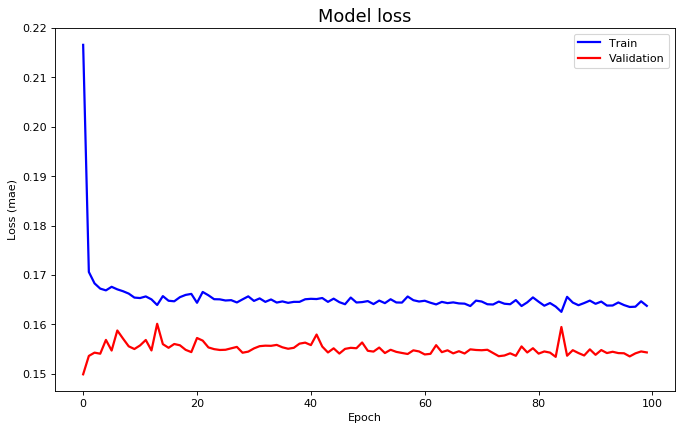

In [184]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [185]:
test_inputs = data[tr_days-lback_days :350].values

test_inputs = test_inputs.reshape(-1,n_features)


test_features = []
for i in range(lback_days, 350-tr_days+lback_days):
    test_features.append(test_inputs[i-lback_days:i, 0])
    
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
predictions = model.predict(test_features)


In [186]:
predictions = scaler.inverse_transform(predictions)

In [187]:
predictions

array([[2.7479758],
       [1.2052689],
       [1.3701782],
       [1.3701782],
       [1.7616775],
       [2.217927 ],
       [1.7616775],
       [2.217927 ],
       [1.0836112],
       [1.0836112],
       [1.2052689],
       [1.7616775],
       [1.0836112],
       [1.2052689]], dtype=float32)

In [188]:
df_frame.iloc[336:,4] #actual value

336    1.0
337    2.0
338    2.0
339    3.0
340    4.0
341    3.0
342    4.0
343    0.0
344    0.0
345    1.0
346    3.0
347    0.0
348    1.0
349    1.0
Name: reviews _ pull_requests, dtype: float64

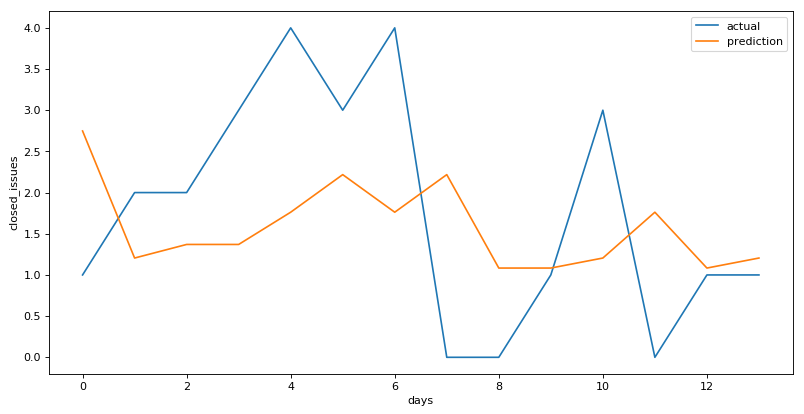

In [190]:
t_data = df_frame.iloc[336:,4].values

fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(t_data, label='actual')
ax.plot(predictions, label='prediction')
ax.set_ylabel('closed_issues')
ax.set_xlabel('days')
ax.legend(loc='upper right')
plt.show()

## Training model with time_step = 3

### Looking at the model loss plot ,it seems that model is close to good fit

In [194]:
scaler = MinMaxScaler()

data = pd.DataFrame(df_frame.iloc[:,4])
data = pd.DataFrame(scaler.fit_transform(data.values))

tr_days = 336
lback_days = 3
n_features = 1
n_predays = 1

features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
model = model_lstm(features_set,n_predays,n_features)

history = model.fit(features_set, labels, epochs = 200, batch_size = 10,validation_split=0.1).history

Train on 300 samples, validate on 34 samples
Epoch 1/200
300/300 [==============================] - 10s 35ms/step - loss: 0.2298 - val_loss: 0.1539
Epoch 2/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1725 - val_loss: 0.1501
Epoch 3/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1709 - val_loss: 0.1507
Epoch 4/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1722 - val_loss: 0.1504
Epoch 5/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1707 - val_loss: 0.1498
Epoch 6/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1725 - val_loss: 0.1507
Epoch 7/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1712 - val_loss: 0.1501
Epoch 8/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1720 - val_loss: 0.1509
Epoch 9/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1714 - val_loss: 0.1506
Epoch 10/200
300/300 [======================

Epoch 81/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1610 - val_loss: 0.1532
Epoch 82/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1604 - val_loss: 0.1531
Epoch 83/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1599 - val_loss: 0.1532
Epoch 84/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1597 - val_loss: 0.1526
Epoch 85/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1609 - val_loss: 0.1531
Epoch 86/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1606 - val_loss: 0.1530
Epoch 87/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1600 - val_loss: 0.1531
Epoch 88/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1604 - val_loss: 0.1528
Epoch 89/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1602 - val_loss: 0.1522
Epoch 90/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1611

300/300 [==============================] - 0s 1ms/step - loss: 0.1538 - val_loss: 0.1468
Epoch 161/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1516 - val_loss: 0.1466
Epoch 162/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1528 - val_loss: 0.1445
Epoch 163/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1516 - val_loss: 0.1489
Epoch 164/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1530 - val_loss: 0.1479
Epoch 165/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1524 - val_loss: 0.1514
Epoch 166/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1516 - val_loss: 0.1460
Epoch 167/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1517 - val_loss: 0.1449
Epoch 168/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1518 - val_loss: 0.1477
Epoch 169/200
300/300 [==============================] - 0s 1ms/step - loss: 0.1514 - v

In [195]:
test_inputs = data[tr_days-lback_days :350].values

test_inputs = test_inputs.reshape(-1,n_features)


test_features = []
for i in range(lback_days, 350-tr_days+lback_days):
    test_features.append(test_inputs[i-lback_days:i, 0])
    
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
predictions = model.predict(test_features)

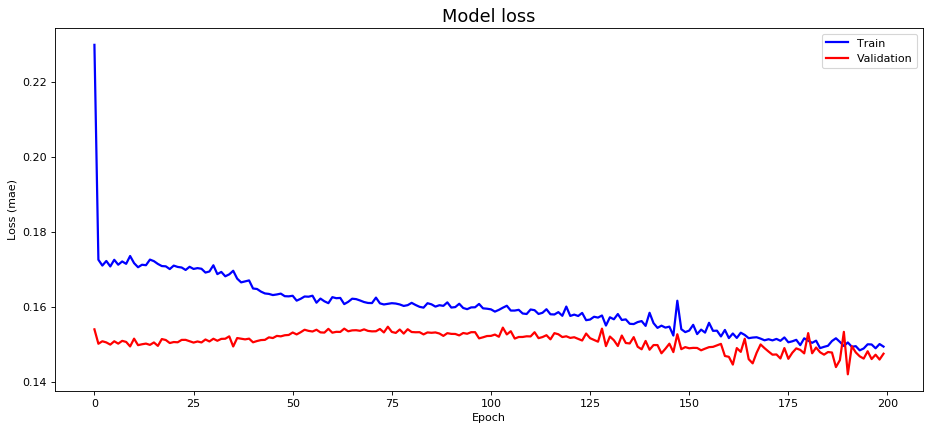

In [196]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [197]:
predictions = scaler.inverse_transform(predictions)

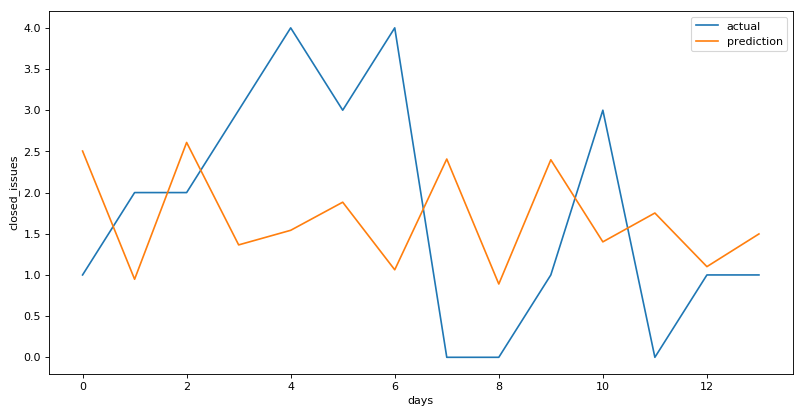

In [198]:

t_data = df_frame.iloc[336:,4].values

fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(t_data, label='actual')
ax.plot(predictions, label='prediction')
ax.set_ylabel('closed_issues')
ax.set_xlabel('days')
ax.legend(loc='upper right')
plt.show()

## Training model with time_step = 5

### Looking at the model loss plot ,it seems that model is overfited

In [199]:
scaler = MinMaxScaler()

data = pd.DataFrame(df_frame.iloc[:,4])
#data = pd.DataFrame(scaler.fit_transform(data.values))

tr_days = 336
lback_days = 5
n_features = 1
n_predays = 1

features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
model = model_lstm(features_set,n_predays,n_features)

history = model.fit(features_set, labels, epochs = 150, batch_size = 10,validation_split=0.2).history

Train on 265 samples, validate on 67 samples
Epoch 1/150
265/265 [==============================] - 12s 44ms/step - loss: 1.5439 - val_loss: 1.5504
Epoch 2/150
265/265 [==============================] - 0s 2ms/step - loss: 1.2231 - val_loss: 1.4282
Epoch 3/150
265/265 [==============================] - 0s 2ms/step - loss: 1.1630 - val_loss: 1.3527
Epoch 4/150
265/265 [==============================] - 0s 2ms/step - loss: 1.1492 - val_loss: 1.4089
Epoch 5/150
265/265 [==============================] - 0s 2ms/step - loss: 1.1373 - val_loss: 1.4456
Epoch 6/150
265/265 [==============================] - 0s 2ms/step - loss: 1.1344 - val_loss: 1.5155
Epoch 7/150
265/265 [==============================] - 0s 1ms/step - loss: 1.1201 - val_loss: 1.4973
Epoch 8/150
265/265 [==============================] - 0s 2ms/step - loss: 1.1166 - val_loss: 1.5437
Epoch 9/150
265/265 [==============================] - 0s 2ms/step - loss: 1.1234 - val_loss: 1.5611
Epoch 10/150
265/265 [======================

Epoch 81/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0764 - val_loss: 1.5074
Epoch 82/150
265/265 [==============================] - 0s 1ms/step - loss: 1.0655 - val_loss: 1.5117
Epoch 83/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0646 - val_loss: 1.4802
Epoch 84/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0695 - val_loss: 1.5217
Epoch 85/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0676 - val_loss: 1.4380
Epoch 86/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0575 - val_loss: 1.5118
Epoch 87/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0676 - val_loss: 1.4413
Epoch 88/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0664 - val_loss: 1.4522
Epoch 89/150
265/265 [==============================] - 0s 1ms/step - loss: 1.0526 - val_loss: 1.5486
Epoch 90/150
265/265 [==============================] - 0s 2ms/step - loss: 1.0616

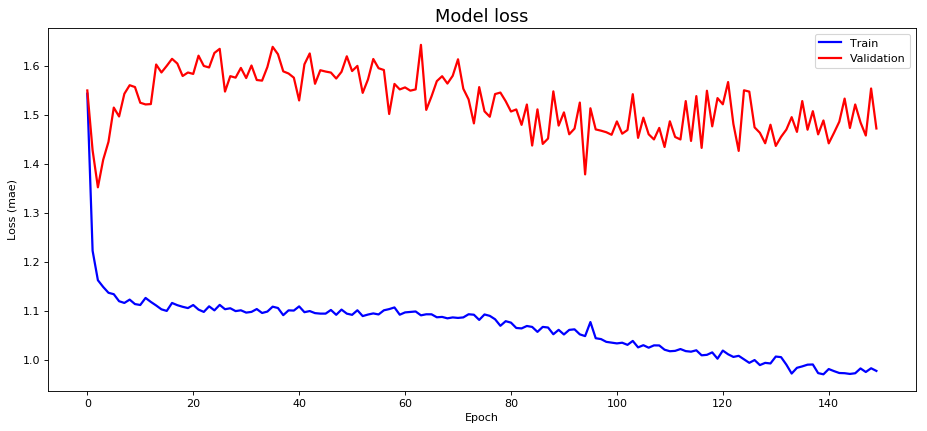

In [200]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [201]:
test_inputs = data[tr_days-lback_days :350].values

test_inputs = test_inputs.reshape(-1,n_features)


test_features = []
for i in range(lback_days, 350-tr_days+lback_days):
    test_features.append(test_inputs[i-lback_days:i, 0])
    
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
predictions = model.predict(test_features)

In [202]:
predictions

array([[2.7119408 ],
       [0.97207355],
       [2.0842972 ],
       [1.5426056 ],
       [1.648236  ],
       [2.2880912 ],
       [0.7341026 ],
       [0.91731745],
       [1.0179603 ],
       [1.5754318 ],
       [1.5208172 ],
       [2.0248559 ],
       [1.2206842 ],
       [1.9957725 ]], dtype=float32)

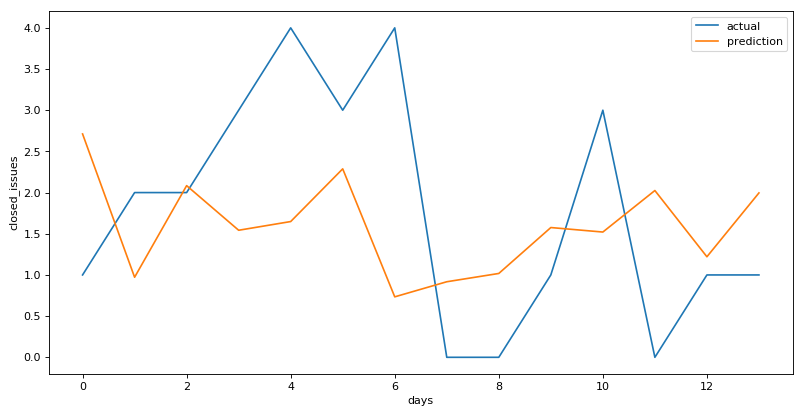

In [204]:
#predictions = scaler.inverse_transform(predictions)
t_data = df_frame.iloc[336:,4].values

fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(t_data, label='actual')
ax.plot(predictions, label='prediction')
ax.set_ylabel('closed_issues')
ax.set_xlabel('days')
ax.legend(loc='upper right')
plt.show()

## Training model with time_step = 7

### Looking at the model loss plot ,it seems that model is overfit

In [205]:
scaler = MinMaxScaler()

data = pd.DataFrame(df_frame.iloc[:,4])
data = pd.DataFrame(scaler.fit_transform(data.values))

tr_days = 336
lback_days = 7
n_features = 1
n_predays = 1

features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
model = model_lstm(features_set,n_predays,n_features)
history = model.fit(features_set, labels, epochs = 100, batch_size = 10,validation_split=0.1).history

Train on 297 samples, validate on 33 samples
Epoch 1/100
297/297 [==============================] - 13s 45ms/step - loss: 0.1990 - val_loss: 0.1601
Epoch 2/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1671 - val_loss: 0.1557
Epoch 3/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1679 - val_loss: 0.1562
Epoch 4/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1673 - val_loss: 0.1588
Epoch 5/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1672 - val_loss: 0.1556
Epoch 6/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1676 - val_loss: 0.1573
Epoch 7/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1677 - val_loss: 0.1563
Epoch 8/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1648 - val_loss: 0.1620
Epoch 9/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1711 - val_loss: 0.1557
Epoch 10/100
297/297 [======================

Epoch 81/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1630 - val_loss: 0.1672
Epoch 82/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1608 - val_loss: 0.1620
Epoch 83/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1595 - val_loss: 0.1637
Epoch 84/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1609 - val_loss: 0.1679
Epoch 85/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1599 - val_loss: 0.1640
Epoch 86/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1599 - val_loss: 0.1640
Epoch 87/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1606 - val_loss: 0.1633
Epoch 88/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1595 - val_loss: 0.1645
Epoch 89/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1595 - val_loss: 0.1642
Epoch 90/100
297/297 [==============================] - 1s 2ms/step - loss: 0.1610

In [206]:
test_inputs = data[tr_days-lback_days :350].values

test_inputs = test_inputs.reshape(-1,n_features)


test_features = []
for i in range(lback_days, 350-tr_days+lback_days):
    test_features.append(test_inputs[i-lback_days:i, 0])
    
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
predictions = model.predict(test_features)

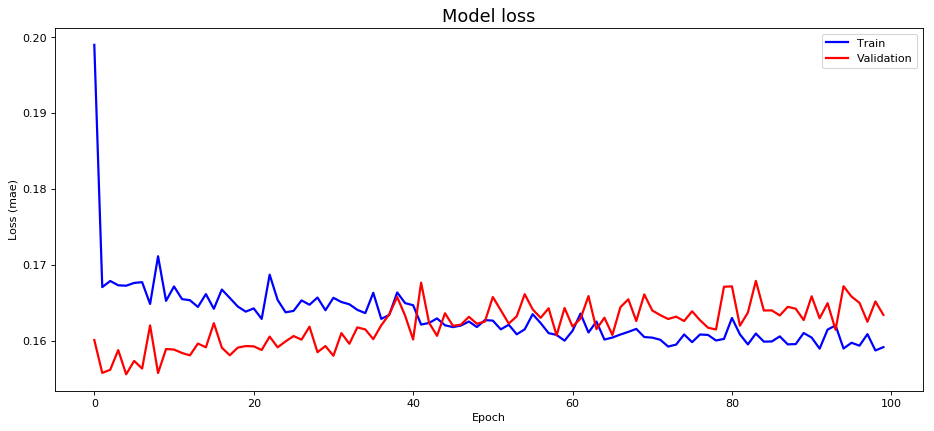

In [207]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

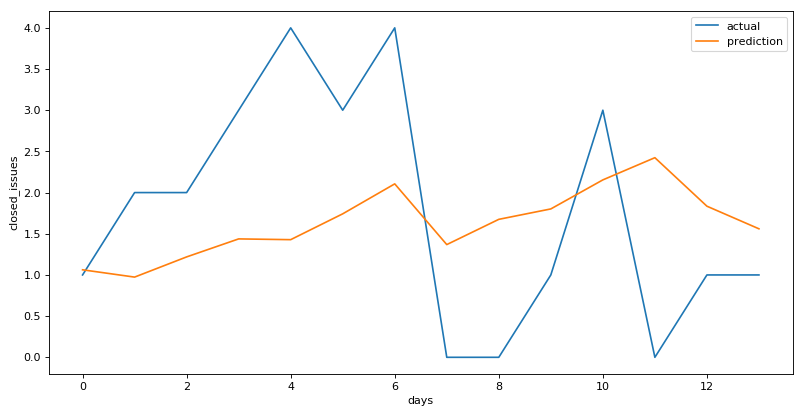

In [208]:
predictions = scaler.inverse_transform(predictions)
t_data = df_frame.iloc[336:,4].values

fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(t_data, label='actual')
ax.plot(predictions, label='prediction')
ax.set_ylabel('closed_issues')
ax.set_xlabel('days')
ax.legend(loc='upper right')
plt.show()